## Random Search for Hyperparameters


https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [2]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split
)

import warnings
warnings.filterwarnings("ignore")

In [3]:
# load data

# scikit-learn dataset
# https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

# dataset information: UCI Machine Learning Repository
# https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
    
# in short, classification problem, trying to predict whether the tumor
# is malignant or benign

# load dataset
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
X.shape

(569, 30)

In [5]:
# target percentage
y.value_counts()/len(y)

0    0.627417
1    0.372583
dtype: float64

In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

In [7]:
# draws a random integer between 1 and 10
stats.randint.rvs(1,10)

# if rvs is not provided, it will give the distribution 
# used in the RandomSearch below

8

In [8]:
# draws a floating number between 0 and 1
stats.uniform.rvs(0, 1)

0.10792582895783631

## Random Search

In [17]:
# set up the GBM
gbm = GradientBoostingClassifier(random_state=0)

# set up the param_grid 
param_grid = dict(n_estimators=stats.randint(1,10), # giving a distribution that can take any value between 1 and 10 
                  min_samples_split=stats.uniform(0,1),
                  max_depth=stats.randint(1,5),
                  loss = ['exponential', 'deviance']
                 )

In [18]:
# set up the search

clf = RandomizedSearchCV(gbm,
                         param_distributions=param_grid,
                         scoring='roc_auc',
                         refit=True, # refit the data with the best params
                         cv=5,# k-fold,
                         n_iter=60, # no of iterations
                         random_state=10,
                         n_jobs=2,
                  )

search = clf.fit(X_train, y_train)

# best hyper parameters
search.best_params_

{'loss': 'exponential',
 'max_depth': 4,
 'min_samples_split': 0.2028029735223642,
 'n_estimators': 8}

In [19]:
# clf is basically a dictionary that returns the scores and other cross validation results
results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005207,0.001169,0.003577,0.001213,deviance,2,0.020752,1,"{'loss': 'deviance', 'max_depth': 2, 'min_samp...",0.912000,0.878333,0.931333,0.934138,0.927551,0.916671,0.020640,49
1,0.004428,0.001490,0.002388,0.000478,deviance,4,0.831911,1,"{'loss': 'deviance', 'max_depth': 4, 'min_samp...",0.896667,0.896667,0.896667,0.918276,0.859184,0.893492,0.019087,56
2,0.003993,0.001096,0.002222,0.000410,deviance,2,0.709208,1,"{'loss': 'deviance', 'max_depth': 2, 'min_samp...",0.896667,0.896667,0.896667,0.918276,0.859184,0.893492,0.019087,56
3,0.006994,0.000911,0.002198,0.000404,exponential,1,0.150378,4,"{'loss': 'exponential', 'max_depth': 1, 'min_s...",0.960000,0.908333,0.935667,0.967931,0.923469,0.939080,0.022229,33
4,0.009206,0.000388,0.002596,0.000486,exponential,1,0.003948,7,"{'loss': 'exponential', 'max_depth': 1, 'min_s...",0.976333,0.954667,0.964667,0.967241,0.925510,0.957684,0.017505,20


In [20]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_loss', 'param_max_depth', 'param_min_samples_split',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [21]:
# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results[[
    'param_max_depth', 'param_min_samples_split', 'param_n_estimators','param_loss',
    'mean_test_score', 'std_test_score',
]].head()

,param_max_depth,param_min_samples_split,param_n_estimators,param_loss,mean_test_score,std_test_score
0,4,0.202803,8,exponential,0.978454,0.012904
1,3,0.35625,9,exponential,0.978311,0.011998
2,4,0.178903,7,deviance,0.976240,0.011546
3,4,0.327144,5,exponential,0.975445,0.012714
4,3,0.373341,7,deviance,0.974968,0.017134


In [22]:
# worst performing models
results[[
    'param_max_depth', 'param_min_samples_split', 'param_n_estimators','param_loss',
    'mean_test_score', 'std_test_score',
]].tail()

,param_max_depth,param_min_samples_split,param_n_estimators,param_loss,mean_test_score,std_test_score
55,2,0.709208,1,deviance,0.893492,0.019087
56,3,0.747582,1,deviance,0.893492,0.019087
57,2,0.695974,1,deviance,0.893492,0.019087
58,4,0.831911,1,deviance,0.893492,0.019087
59,3,0.922233,1,exponential,0.893492,0.019087


Text(0.5, 0, 'Hyperparameter combinations')

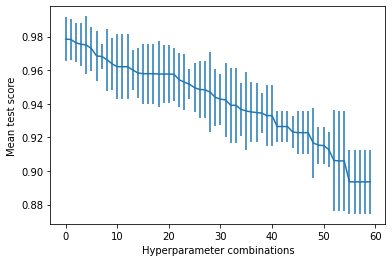

In [23]:
# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [24]:
# get the predictions

preds_train = search.predict_proba(X_train)[:,1]
preds_test = search.predict_proba(X_test)[:,1]

print('Train data score : {}'.format(roc_auc_score(y_train, preds_train)))
print('Test data score : {}'.format(roc_auc_score(y_test, preds_test)))

Train data score : 0.9969003530902132
Test data score : 0.9839065255731922


In [25]:
# lets check the performance based on single hyper parameter

def summarize_by_param(param):
    tmp = pd.concat([
        results.groupby(param)['mean_test_score'].mean(), 
        results.groupby(param)['mean_test_score'].std()
        ], axis = 1)
    tmp.columns = ['mean_test_score','std_test_score']
    
    return tmp    

In [26]:
temp = summarize_by_param('param_n_estimators')
temp.head()

,mean_test_score,std_test_score
param_n_estimators,,
1,0.909991,0.014303
2,0.930562,0.015840
3,0.935713,0.018023
4,0.945818,0.007839
5,0.956278,0.012947


Text(0, 0.5, 'roc_auc')

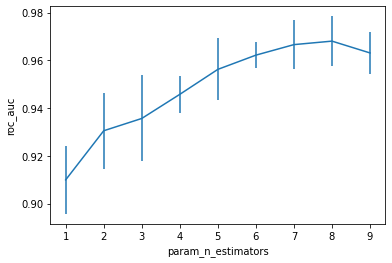

In [27]:
temp['mean_test_score'].plot(yerr=(temp['std_test_score'],temp['std_test_score']))
plt.ylabel('roc_auc')

The optimal hyperparameter seems to be somewhere between 7 to 9.

In [28]:
# similary check for other params
temp = summarize_by_param('param_max_depth')
temp.head()

,mean_test_score,std_test_score
param_max_depth,,
1,0.948778,0.012408
2,0.933188,0.022890
3,0.940713,0.026379
4,0.946077,0.027734


Text(0, 0.5, 'roc_auc')

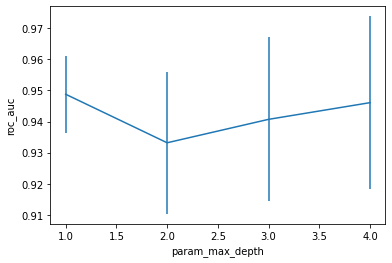

In [29]:
temp['mean_test_score'].plot(yerr=(temp['std_test_score'],temp['std_test_score']))
plt.ylabel('roc_auc')

- Optimal hyper param value lies somewhere between 2 and 4

In [30]:
# similarly for the last param
temp = summarize_by_param('param_min_samples_split')
temp.head()

,mean_test_score,std_test_score
param_min_samples_split,,
0.000273,0.943846,NaN
0.003948,0.957684,NaN
0.020752,0.916671,NaN
0.023432,0.957893,NaN
0.025400,0.957684,NaN


Text(0, 0.5, 'roc_auc')

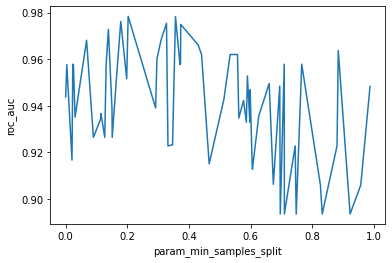

In [31]:
temp['mean_test_score'].plot(yerr=(temp['std_test_score'],temp['std_test_score']))
plt.ylabel('roc_auc')

- This one doesnt seem to have much impact on the performance

(0.8, 1.0)

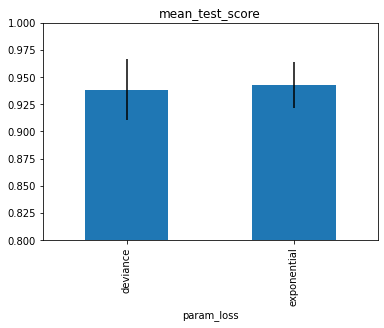

In [34]:
tmp = summarize_by_param('param_loss')
tmp['mean_test_score'].plot.bar(yerr=[tmp['std_test_score'], tmp['std_test_score']], subplots=True)
plt.ylim(0.8, 1)